In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pymc3 as pm
import arviz as az

In [10]:
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (15, 10)

## Modeling functions

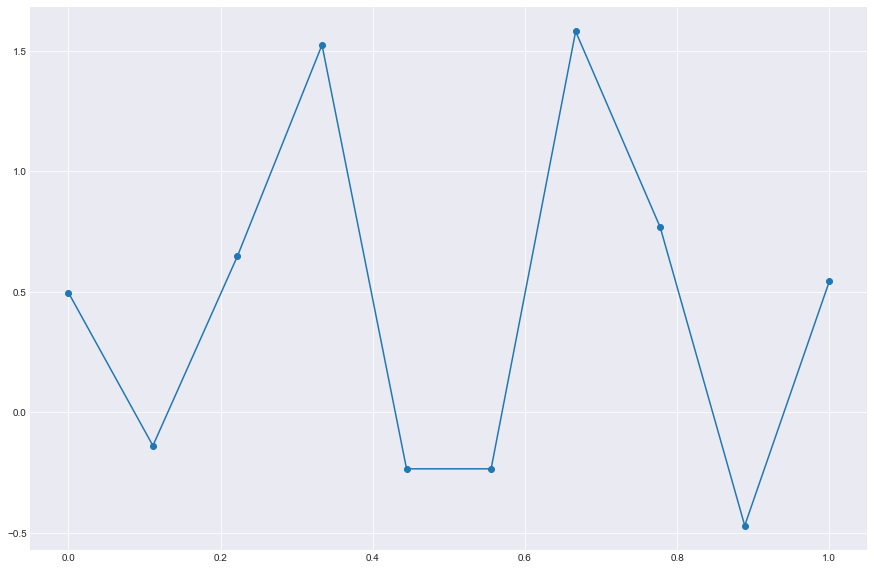

In [15]:
np.random.seed(42)
x = np.linspace(0, 1, 10)
y = np.random.normal(0, 1, len(x))
plt.plot(x, y, 'o-', label='1')

In [16]:
def exp_quad_kernel(x, knots, ℓ=1):
    """Exponentiated quadratic kernel"""
    return np.array([np.exp(-(x - k)**2 / (2 * ℓ**2)) for k in knots])

In [17]:
np.exp(-2)

0.1353352832366127

In [18]:
np.exp(-9 / 2)

0.011108996538242306

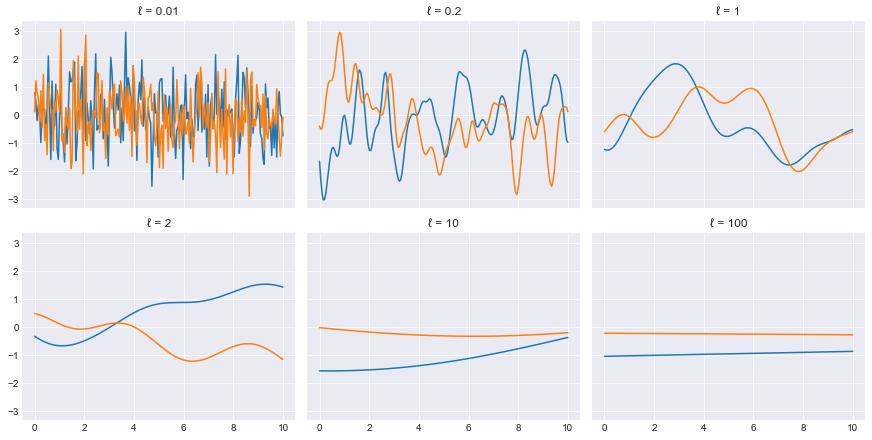

In [33]:
np.random.seed(24)
points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)
ax = np.ravel(ax)
for (i, ℓ) in enumerate([0.01, 0.2, 1, 2, 10, 100]):
    cov = exp_quad_kernel(points, points , ℓ)
    ax[i].plot(points, stats.multivariate_normal.rvs(cov=cov, size=2).T, '-')
    ax[i].set_title(f'ℓ = {ℓ}')

## Gaussian process regression

Text(0,0.5,'f(x)')

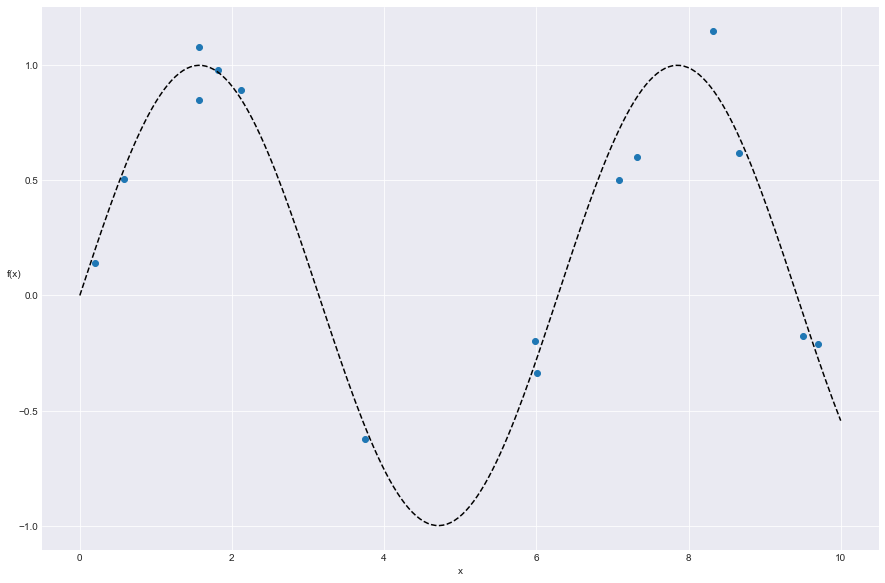

In [38]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0)

In [41]:
X = x[:, None]
with pm.Model() as model_reg:
    # hyperprior for the length-scale parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instantiate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instantiate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    ϵ = pm.HalfNormal('ϵ', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)
    trace_reg = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, ℓ]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:11<00:00, 418.09draws/s]


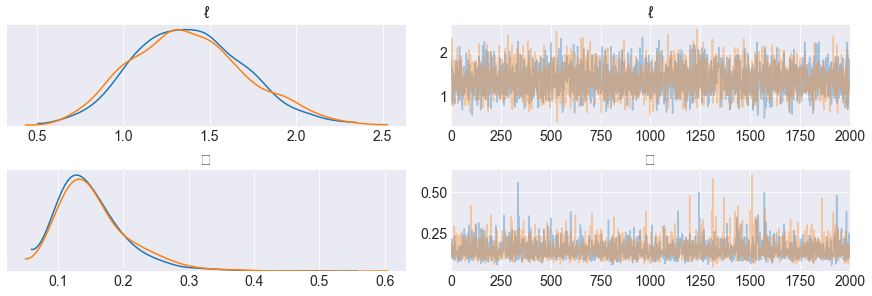

In [45]:
az.plot_trace(trace_reg);

In [59]:
X_new = np.linspace(np.floor(x.min() - 10), np.ceil(x.max() + 10), 100)[:, None]

In [61]:
with model_reg:
    f_pred = gp.conditional('f_pred2', X_new)

In [63]:
with model_reg:
    pred_samples = pm.sample_posterior_predictive(trace_reg, vars=[f_pred], samples=82)

100%|██████████| 82/82 [00:00<00:00, 92.05it/s]


Text(0.5,0,'X')

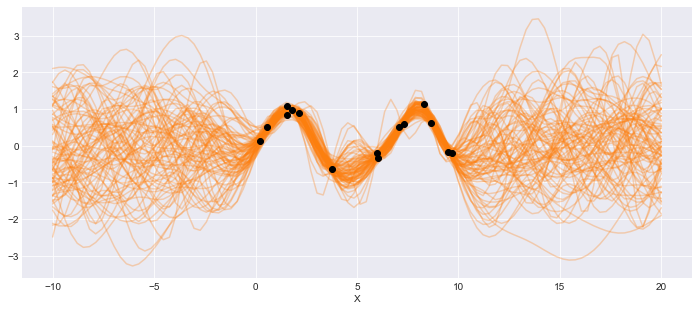

In [65]:
_, ax = plt.subplots(figsize=(12, 5))
ax.plot(X_new, pred_samples['f_pred2'].T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')

Text(0,0.5,'f(x)')

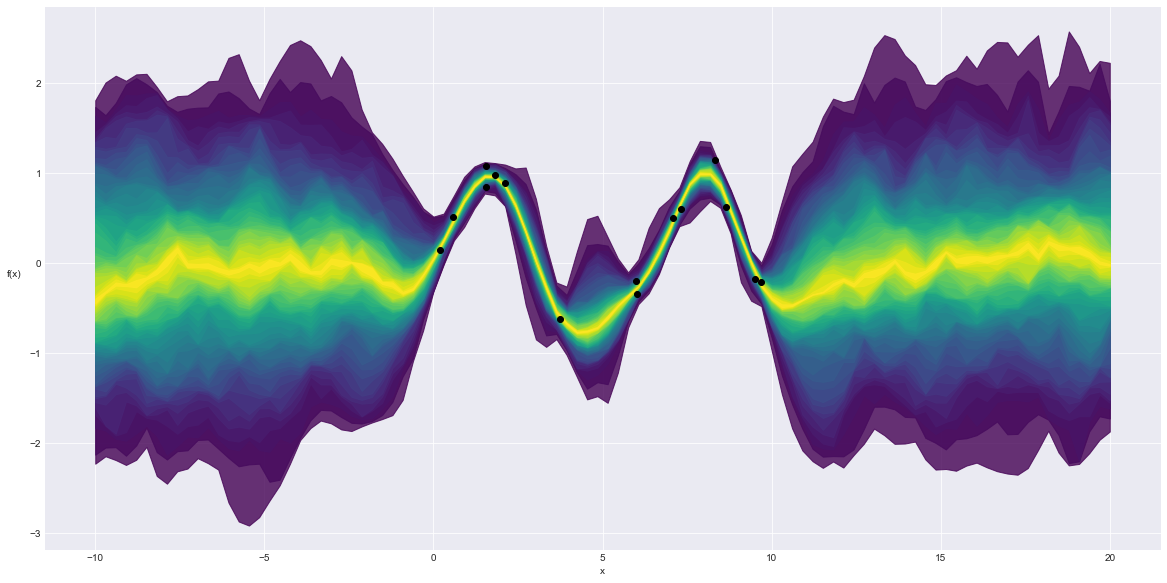

In [68]:
_, ax = plt.subplots(figsize=(20, 10))

pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred2'], X_new, palette='viridis', plot_samples=False)

ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)

## Regression with spatial autocorrelation

In [1]:
import pandas as pd

In [2]:
islands_dist = pd.read_csv('../data/islands_dist.csv', sep=',', index_col=0)

In [3]:
islands_dist.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


In [4]:
islands = pd.read_csv('../data/islands.csv', sep=',')
islands.round(1)

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.0
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.3
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.2
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.5
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.9
5,Trobriand,8000,high,19,4.0,-8.7,150.9,-29.1,9.0
6,Chuuk,9200,high,40,3.8,7.4,151.6,-28.4,9.1
7,Manus,13000,low,28,6.6,-2.1,146.9,-33.1,9.5
8,Tonga,17500,high,55,5.4,-21.2,-175.2,4.8,9.8
9,Hawaii,275000,low,71,6.6,19.9,-155.6,24.4,12.5


In [5]:
import seaborn as sns

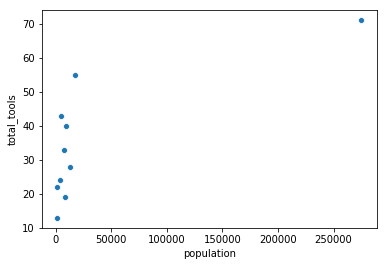

In [6]:
sns.scatterplot(x='population', y='total_tools', data=islands)

In [8]:
islands_dist_sqr = islands_dist.values**2
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

In [25]:
pd.DataFrame(islands_dist_sqr).round(1)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.2,0.4,19.0,1.5,4.1,10.1,7.8,3.5,32.2
1,0.2,0.0,0.1,17.4,1.5,4.0,8.3,7.1,3.9,27.9
2,0.4,0.1,0.0,14.9,2.4,2.9,6.7,5.6,5.2,29.2
3,19.0,17.4,14.9,0.0,29.1,6.1,2.4,2.6,37.7,51.5
4,1.5,1.5,2.4,29.1,0.0,10.4,16.2,15.3,0.6,23.9
5,4.1,4.0,2.9,6.1,10.4,0.0,3.2,0.7,15.2,44.3
6,10.1,8.3,6.7,2.4,16.2,3.2,0.0,1.5,22.9,33.5
7,7.8,7.1,5.6,2.6,15.3,0.7,1.5,0.0,21.4,45.2
8,3.5,3.9,5.2,37.7,0.6,15.2,22.9,21.4,0.0,25.4
9,32.2,27.9,29.2,51.5,23.9,44.3,33.5,45.2,25.4,0.0


In [13]:
with pm.Model() as model_islands:
    η = pm.HalfCauchy('η', 1)
    ℓ = pm.HalfCauchy('ℓ', 1)
    cov = η * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=islands_dist_sqr) # This is probably related to (6.66) and (6.67) in Bisshop
    
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + f[index] + β * log_pop)
    tt_pred = pm.Poisson('tt_pred', μ, observed=total_tools)
    trace_islands = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α, f_rotated_, ℓ, η]
Sampling 2 chains: 100%|██████████| 4000/4000 [01:53<00:00, 35.32draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


To compute the value of the posterior of a Gaussian process at a point x one only requires the data points (x_i, y_i), the value of the kernel on k(x_i, x) and k(x, x). However, I still don't understand why we may pass the `islands_dist_sqr` matrix to `gp.prior`, as `gp.prior` simply seems to compute the projection of the Gaussian process onto the points in `X`. Also, how would the function know that the distances in the `X` matrix are to be interpreted as exponents in exponential quadratic kernel? This trick would also only work for stationary kernels (i.e., kernels that depend on their inputs only through the distance between those inputs).

Text(0,0.5,'covariance')

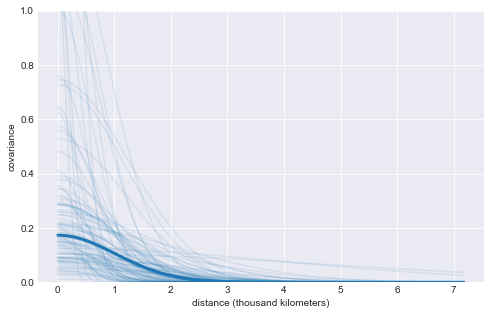

In [32]:
trace_η = trace_islands['η']
trace_ℓ = trace_islands['ℓ']
_, ax = plt.subplots(1, 1, figsize=(8, 5))
xrange = np.linspace(0, islands_dist.values.max(), 100)
ax.plot(xrange, np.median(trace_η) * np.exp(-np.median(trace_l) * xrange**2), lw=3)
ax.plot(xrange, (trace_η[::20][:, None] * np.exp(- trace_l[::20][:, None] * xrange**2)).T, 'C0', alpha=.1)
ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance')

In [34]:
trace_islands['f'].shape

(2000, 10)

## The coal-mining disasters

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

In [8]:
df = pd.read_csv('../data/coal.csv', header=None)
print(f'Count: {len(df)}')
print(f'Range: [{df[0].min(), df[0].max()}]')
df.head()

Count: 191
Range: [(1851.2026, 1962.2197)]


,0
0,1851.2026
1,1851.6324
2,1851.9692
3,1851.9747
4,1852.3142


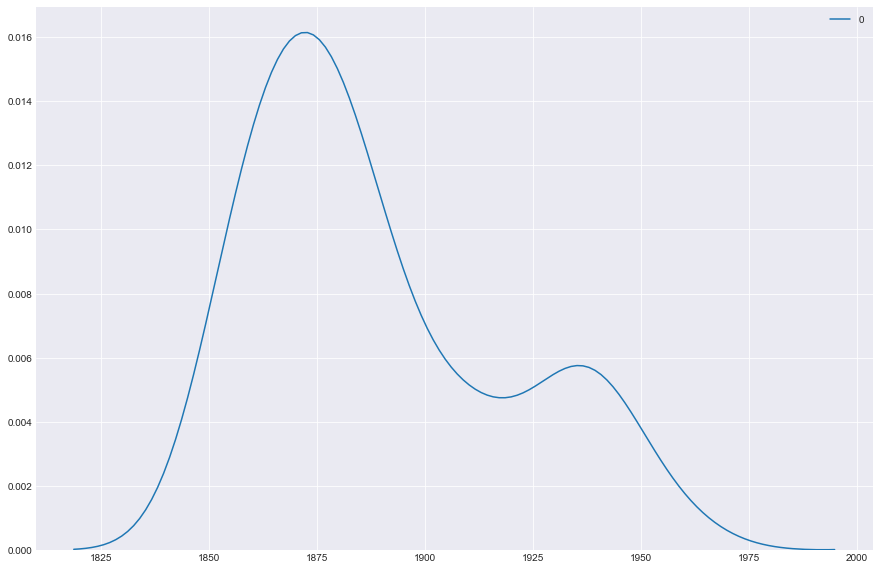

In [14]:
sns.kdeplot(df[0]);

In [16]:
years = int(df.max().values - df.min().values)
bins = years // 4
hist, x_edges = np.histogram(df, bins=bins)
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
x_data = x_centers[:, None]
y_data = hist / 4

In [22]:
with pm.Model() as model_coal:
    ℓ = pm.HalfNormal('ℓ', x_data.std())
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x_data)
    
    Y_pred = pm.Poisson('y_pred', mu=pm.math.exp(f), observed=y_data)
    trace_coal = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]
100%|██████████| 1500/1500 [00:15<00:00, 94.05it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


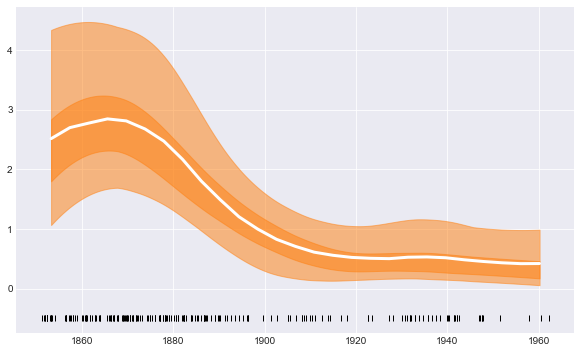

In [26]:
_, ax = plt.subplots(figsize=(10, 6))
f_trace = np.exp(trace_coal['f'])
rate_median = np.median(f_trace, axis=0)
ax.plot(x_centers, rate_median, 'w', lw=3)
az.plot_hpd(x_centers, f_trace)
az.plot_hpd(x_centers, f_trace, credible_interval=0.5, plot_kwargs={'alpha': 0})
ax.plot(df, np.zeros_like(df)-0.5, 'k|')
ax.set_label('years')
ax.set_label('rate')

This is a good page on how to pick a kernel for Gaussian process regression: https://www.cs.toronto.edu/~duvenaud/cookbook/